In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from meteostat import Point, Daily
from datetime import datetime
import seaborn as sns
from matplotlib.cm import get_cmap


# Step 1: Load and Prepare Data

In [15]:

def load_data(file_paths):
    dataframes = {}
    for year, path in file_paths.items():
        df = pd.read_excel(path, header=None)  # Adjust header if necessary
        df.columns = ['Month', 'Energy_Production']
        # Convert all non-numeric data to NaN and drop invalid rows
        df['Energy_Production'] = pd.to_numeric(df['Energy_Production'], errors='coerce')
        df.dropna(subset=['Energy_Production'], inplace=True)
        dataframes[year] = df
    combined_df = pd.concat(dataframes.values(), ignore_index=True)
    return combined_df

file_paths = {
   '2020': r'C:\Users\hp\OneDrive\Desktop\2020.xlsx',
    '2021': r'C:\Users\hp\OneDrive\Desktop\2021.xlsx',
    '2022': r'C:\Users\hp\OneDrive\Desktop\2022.xlsx',
    '2023': r'C:\Users\hp\OneDrive\Desktop\2023.xlsx',
    '2024': r'C:\Users\hp\OneDrive\Desktop\2024.xlsx'
}
data = load_data(file_paths)

# Step 2: Handle Missing Data

In [16]:


data['Energy_Production'].fillna(data['Energy_Production'].mean(), inplace=True)


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




# Step 3: Fetch Weather Data Using Meteostat

In [17]:

def fetch_weather_data(start_year, end_year):
    location = Point(32.2211, 35.2602, 40)  # Nablus coordinates
    start = datetime(start_year, 1, 1)
    end = datetime(end_year, 12, 31)

    # Fetch daily weather data
    weather_data = Daily(location, start, end)
    weather_data = weather_data.fetch()

    # Extract monthly averages for temperature
    weather_data['month'] = weather_data.index.month
    monthly_avg = weather_data.groupby('month')["tavg"].mean().reset_index()
    monthly_avg.columns = ['Month', 'Weather_Condition']
    return monthly_avg

# Fetch and process weather data
weather_data = fetch_weather_data(2020, 2024)

# Step 4: Merge Energy Data with Weather Data
data = pd.merge(data, weather_data, on='Month', how='left')

# Verify merged data
print(data.head())

  Month  Energy_Production  Weather_Condition
0   1.0              504.4           7.796129
1   2.0              640.9           8.685915
2   3.0              771.5          11.470323
3   4.0              921.1          16.769333
4   5.0             1093.2          20.104516


# Step 4: Merge Energy Data with Weather Data

In [18]:

# Drop any existing 'Weather_Condition' column from the data DataFrame
if 'Weather_Condition' in data.columns:
    data = data.drop(columns=['Weather_Condition'])  
    

# Merge with custom suffixes to avoid conflicts
data = pd.merge(data, weather_data, on='Month', how='left', suffixes=('_energy', '_weather'))

# Verify the merged data
print(data.head())

  Month  Energy_Production  Weather_Condition
0   1.0              504.4           7.796129
1   2.0              640.9           8.685915
2   3.0              771.5          11.470323
3   4.0              921.1          16.769333
4   5.0             1093.2          20.104516


# Step 5: Visualization 

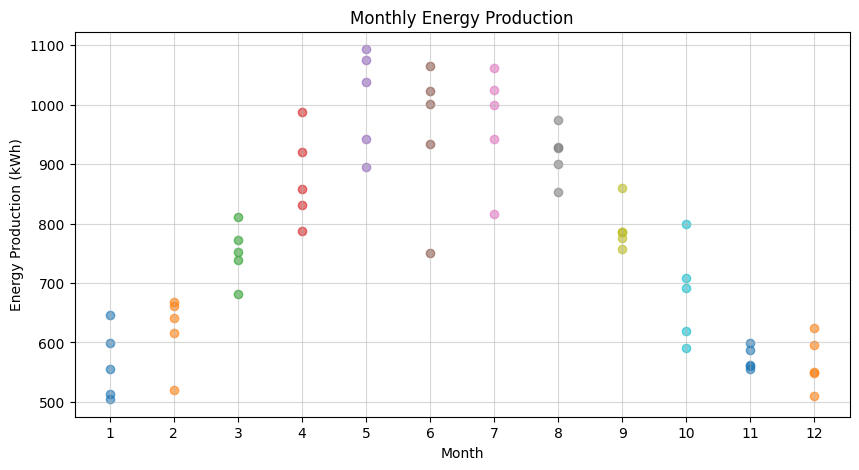

In [19]:

# Visualization 1: Scatter plot of energy production for each month
def plot_monthly_energy(data):
    plt.figure(figsize=(10, 5))
    for month in data['Month'].unique():
        month_data = data[data['Month'] == month]
        plt.scatter([month] * len(month_data), month_data['Energy_Production'], label=f'Month {month}', alpha=0.6)
    plt.title('Monthly Energy Production')
    plt.xlabel('Month')
    plt.ylabel('Energy Production (kWh)')
    plt.xticks(range(1, 13))
    plt.grid(alpha=0.5)
    plt.show()

plot_monthly_energy(data)

# Step 6: Prepare Data for Modeling

In [20]:

X = data[['Weather_Condition']]
y = data['Energy_Production']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 7: Train Models

In [21]:

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Adding ensemble learning models
voting_model = VotingRegressor([('lr', LinearRegression()), ('dt', DecisionTreeRegressor(random_state=42)), ('rf', RandomForestRegressor(random_state=42))])
stacking_model = StackingRegressor(estimators=[('lr', LinearRegression()), ('dt', DecisionTreeRegressor(random_state=42))], final_estimator=RandomForestRegressor(random_state=42))
models['Voting Regressor'] = voting_model
models['Stacking Regressor'] = stacking_model

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)   # Added RMSE Calculation
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}  


# Function to Plot Monthly Comparisons
def plot_monthly_comparison(data, model, X, y):
    data['Predicted_Energy'] = model.predict(X)
    monthly_comparison = data.groupby('Month')[['Energy_Production', 'Predicted_Energy']].mean()

    plt.figure(figsize=(10, 6))
    monthly_comparison.plot(kind='bar', ax=plt.gca(), alpha=0.75)
    plt.title('Monthly Energy Production vs Predictions')
    plt.xlabel('Month')
    plt.ylabel('Energy Production (kWh)')
    plt.xticks(rotation=0)
    plt.legend(['Actual', 'Predicted'])
    plt.show()


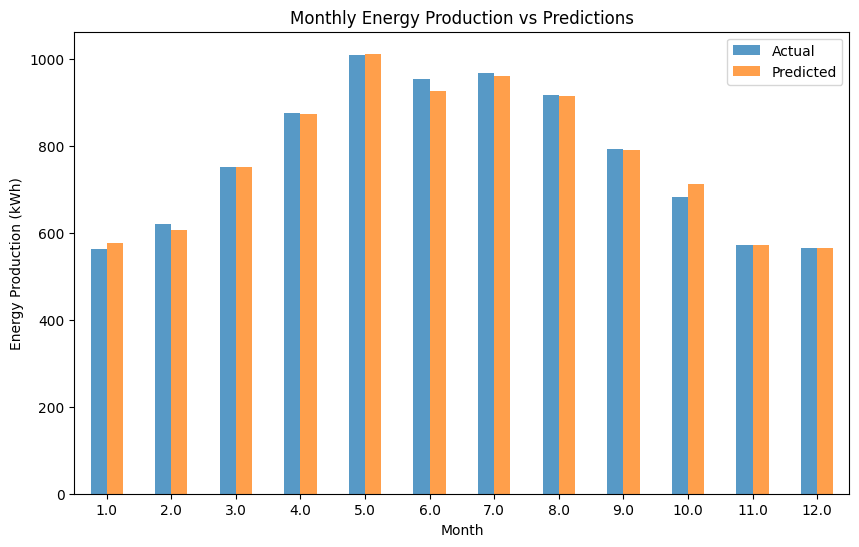

In [22]:

# Plot Initial Predictions
plot_monthly_comparison(data, models['Random Forest'], X, y)




# Hyperparameter Tuning

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best R2 Score: 0.4432510387151007


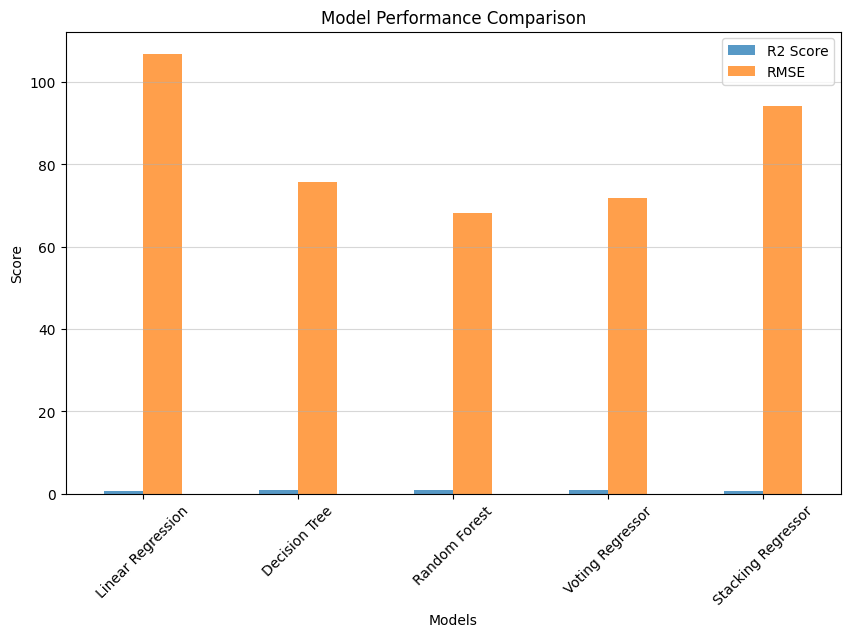

In [23]:

def tune_hyperparameters(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2') # A dictionary defining the hyperparameters to search over and their possible values.
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best R2 Score:", grid_search.best_score_)
    return grid_search.best_estimator_

rf_param_grid = {
     'n_estimators': [50, 100, 150], # Number of trees in the forest
     'max_depth': [None, 10, 20],# Maximum depth of trees
     'min_samples_split': [2, 5], # Min samples required to split an internal node
     'min_samples_leaf': [1, 2, 4]# Min samples required at a leaf node
}
best_rf_model = tune_hyperparameters(X_train, y_train, RandomForestRegressor(random_state=42), rf_param_grid)

def plot_model_performance(results):    
    metrics_df = pd.DataFrame(results).T  
    # Convert results dictionary to DataFrame\n    
    metrics_df = metrics_df[['R2', 'RMSE']]  # Focus on R2 and RMSE\n    
    metrics_df.plot(kind='bar', figsize=(10, 6), alpha=0.75, rot=0)    
    plt.title('Model Performance Comparison')    
    plt.ylabel('Score')    
    
    plt.xlabel('Models')   
    plt.xticks(rotation=45)    
    plt.legend(['R2 Score', 'RMSE'], loc='best')    
    plt.grid(axis='y', alpha=0.5)    
    plt.show()# Call the function to display the performance plot\
    
plot_model_performance(results)


# Visualize Tuned Model

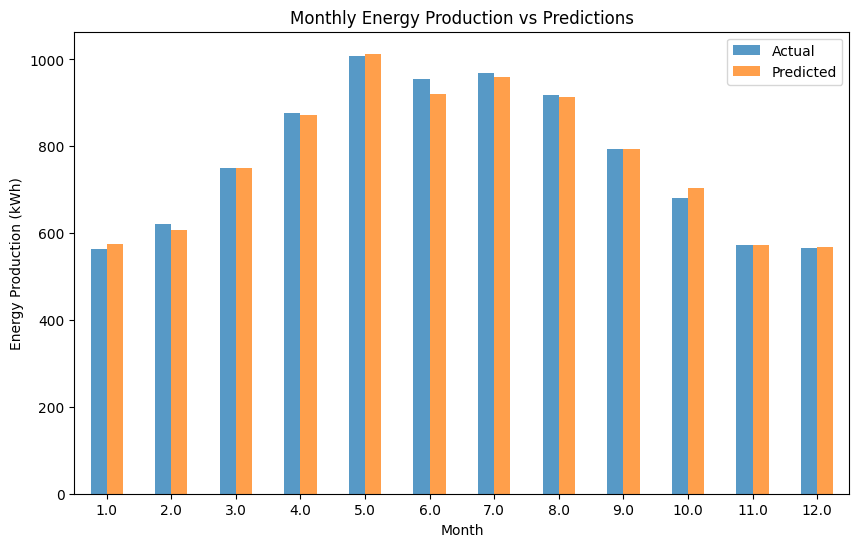

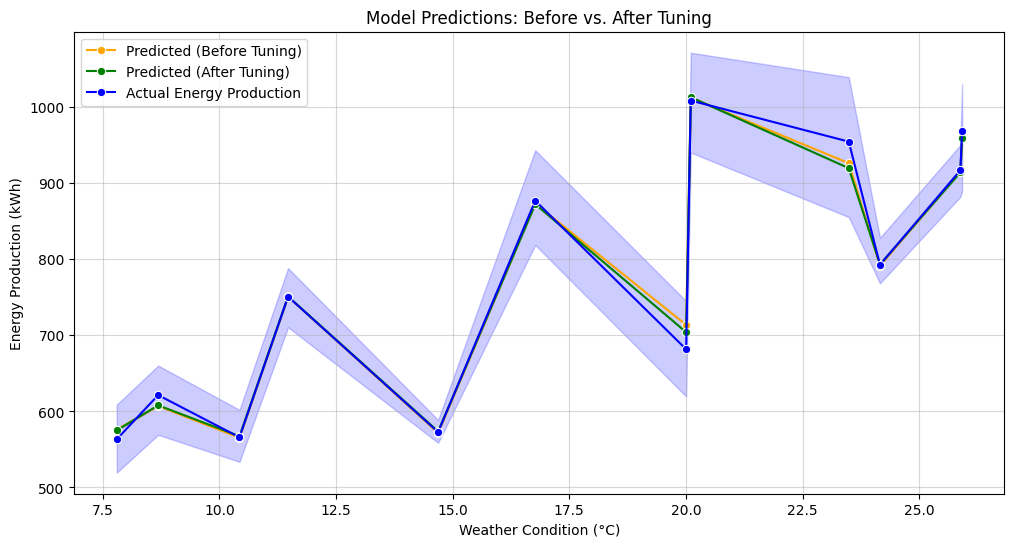

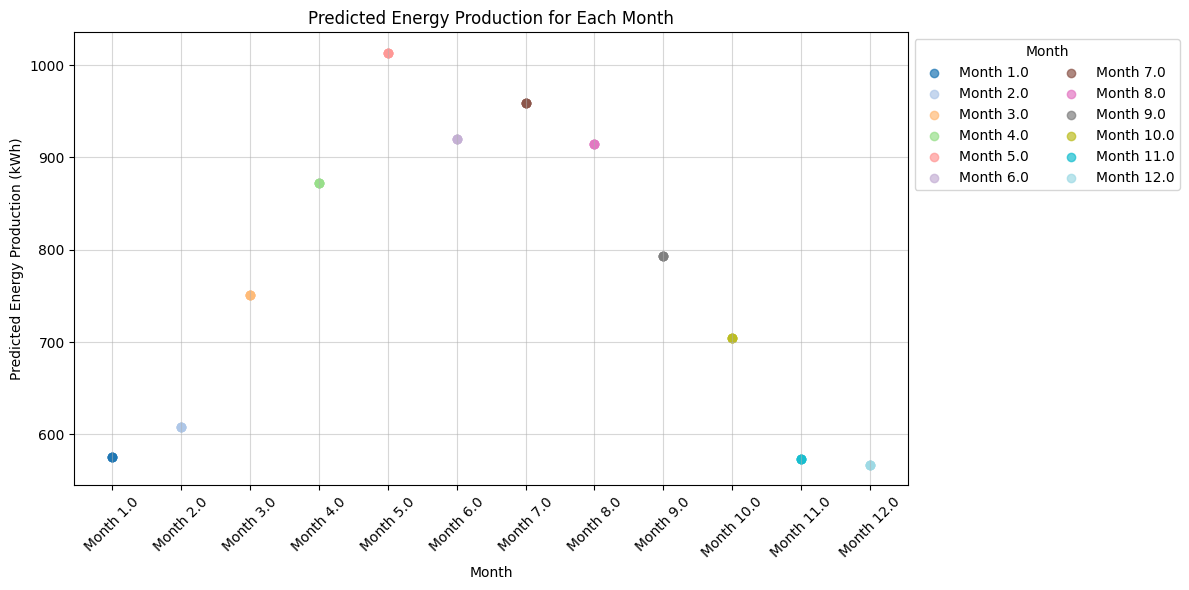

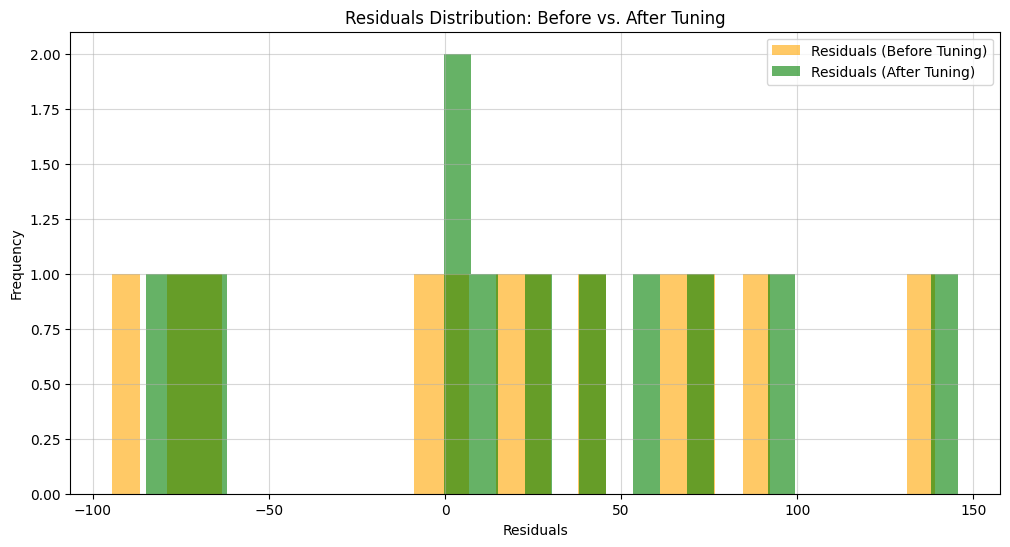

In [24]:

plot_monthly_comparison(data, best_rf_model, X, y)


    
# Visualization 2: Scatter plot of weather data vs energy production
#def plot_weather_vs_energy(data):
 #   plt.figure(figsize=(10, 5))
#    plt.scatter(data['Weather_Condition'], data['Energy_Production'], alpha=0.7, c='blue')
 #   plt.title('Weather Conditions vs Energy Production')
 #   plt.xlabel('Weather Condition (°C)')
 #   plt.ylabel('Energy Production (kWh)')
 #   plt.grid(alpha=0.5)
 #   plt.show()

# visualize how the predictions differ before and after hyperparameter tuning
def plot_predictions_comparison(data, model_before, model_after, X, y):
    # Predict with both models
    data['Predicted_Before'] = model_before.predict(X)
    data['Predicted_After'] = model_after.predict(X)

    plt.figure(figsize=(12, 6))

    # Create a line plot to visualize trends for better readability
    sns.lineplot(data=data, x='Weather_Condition', y='Predicted_Before', label='Predicted (Before Tuning)', color='orange', marker='o')
    sns.lineplot(data=data, x='Weather_Condition', y='Predicted_After', label='Predicted (After Tuning)', color='green', marker='o')
    sns.lineplot(data=data, x='Weather_Condition', y=y, label='Actual Energy Production', color='blue', marker='o')

    plt.title('Model Predictions: Before vs. After Tuning')
    plt.xlabel('Weather Condition (°C)')
    plt.ylabel('Energy Production (kWh)')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()
    


plot_predictions_comparison(data, models['Random Forest'], best_rf_model, X, y)

  

# Call the functions to generate the plots
#plot_weather_vs_energy(data)

def plot_residuals(y_true, y_pred_before, y_pred_after):
    residuals_before = y_true - y_pred_before
    residuals_after = y_true - y_pred_after

    plt.figure(figsize=(12, 6))
    plt.hist(residuals_before, bins=30, alpha=0.6, label='Residuals (Before Tuning)', color='orange')
    plt.hist(residuals_after, bins=30, alpha=0.6, label='Residuals (After Tuning)', color='green')

    plt.title('Residuals Distribution: Before vs. After Tuning')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()


def plot_month_vs_predicted_energy(data):
    plt.figure(figsize=(12, 6))
    months = sorted(data['Month'].unique())  
    num_months = len(months)

    
    colors = get_cmap('tab20', num_months).colors  

    for i, month in enumerate(months):
        month_data = data[data['Month'] == month]
        plt.scatter(
            [month] * len(month_data),  
            month_data['Predicted_Energy'],
            label=f'Month {month}',
            color=colors[i % len(colors)],  
            alpha=0.7
        )

    plt.title('Predicted Energy Production for Each Month')
    plt.xlabel('Month')
    plt.ylabel('Predicted Energy Production (kWh)')
    plt.xticks(ticks=months, labels=[f'Month {i}' for i in months], rotation=45)  
    plt.grid(alpha=0.5)
    plt.legend(title='Month', loc='upper left', bbox_to_anchor=(1, 1), ncol=2)  
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_month_vs_predicted_energy(data)
# Example usage
plot_residuals(y_test, models['Random Forest'].predict(X_test), best_rf_model.predict(X_test))
    

# Step 8: Display Results

In [25]:

print("Model Performance:")
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.2f}, R2 = {metrics['R2']:.2f}")

best_model = max(results, key=lambda name: results[name]['R2'])
print(f"Best model: {best_model}")

Model Performance:
Linear Regression: MSE = 11436.68, R2 = 0.60
Decision Tree: MSE = 5743.51, R2 = 0.80
Random Forest: MSE = 4637.04, R2 = 0.84
Voting Regressor: MSE = 5156.78, R2 = 0.82
Stacking Regressor: MSE = 8852.44, R2 = 0.69
Best model: Random Forest


# Step 9: Export Results

In [26]:

data['Predicted_Energy'] = best_rf_model.predict(X)
data.to_csv('predicted_energy_tuned.csv', index=False)
print("Tuned results exported to 'predicted_energy_tuned.csv'")


Tuned results exported to 'predicted_energy_tuned.csv'
